# Linear Regression

We can think of linear regression as the "grandfather" of supervised machine learning.  It developed as an important technique in statistics long before machine learning existed as a field in its own right.  The idea in supervised learning is that we have a data set called the **training data**.  The training data consists of a set of pairs $\{ \, ( \mathbf{x}_1,y_1 ), ( \mathbf{x}_2,y_2 ) \ldots,  ( \mathbf{x}_m,y_m ) \, \}$, where each input variable $\mathbf{x}_i$ is a vector called a **feature vector**, and the output variables $y_i$ are the corresponding **labels**.  

If $\mathcal{X}$ is the input space and $\mathcal{Y}$ is the output space, then the objective of a supervised learning algorithm is to "learn" a function $h: \mathcal{X} \rightarrow \mathcal{Y}$ that approximates the training data and will generalize in order to predict the output for new instances.  When the target space $\mathcal{Y}$ consists of continuous data, then the learning problem is called a **regression** problem.  When the target space $\mathcal{Y}$ consists of discrete data, then the learning problem is called a **classification** problem.

### Simple Linear Regression

In simple linear regression, we have $\mathcal{X} = \mathcal{Y} = \mathbb{R}$, so that $h: \mathbb{R} \rightarrow \mathbb{R}$ is a function from the real numbers to the real numbers, and $h$ is a linear function of the form $h_{\theta}(x) = \theta_0 + \theta_1 x$, where $\theta_1, \theta_2$ are called the **weights**.  The training data will then consist of a bunch of points in the plane, and we are trying the find a line that "best fits" the data.  This line is called the **least squares line**  (image from [wikipedia](https://en.wikipedia.org/wiki/Linear_regression))

<br/>
<img src="least_squares_line.png">
<br/>

Now let's look at an example.  This example comes from one of the programming exercises in Andrew Ng's machine learning course.  Suppose you are the CEO of a food truck franchise and you are considering different cities where you can expand your business.  Your chain already has trucks in a number of cities and you have [data](https://github.com/marty-vanhoof/Maching_Learning/blob/master/data/ex1data1.txt) about the population of each city and the profit of the corresponding food truck.  You would like to estimate the expected profit of a new food truck given only the population of a city (admittedly this example is a little simplistic, but it's good for illustrating the main ideas in linear regression).

We will use Pandas to analyze the data.  First we import the modules that we need.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Next let's load the dataframe and take a look at the first 5 rows.  The population and profit columns are in units of $10000, so to get the actual numbers just multiply by 10000.  We can also use Panda's ```describe()``` function to get some statistics about the dataset.

In [2]:
filepath = os.getcwd() + '/ex1data1.txt'
df = pd.read_csv(filepath, names = ['population', 'profit'])
df.head()

,population,profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


In [3]:
# get some basic statistics
df.describe().apply(lambda x: x.round(4))

,population,profit
count,97.0000,97.0000
mean,8.1598,5.8391
std,3.8699,5.5103
min,5.0269,-2.6807
25%,5.7077,1.9869
50%,6.5894,4.5623
75%,8.5781,7.0467
max,22.2030,24.1470


A scatterplot of the data suggests a positive correlation between population and profit, and many of the data points cluster around cities with lower populations. 

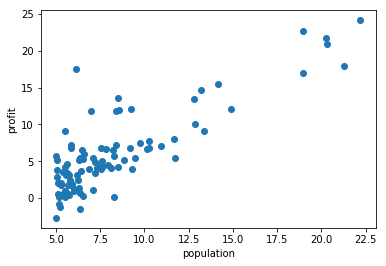

In [4]:
# Make a scatterplot of the data
plt.scatter(df.population, df.profit)
plt.xlabel('population')
plt.ylabel('profit')
plt.show()

### The Gradient Descent Algorithm

Let's write the feature vector $\mathbf{x}_i$ as a row vector $\mathbf{x}_i = (x_{i0}, x_{i1}, \dots, x_{in})$, where $x_{i0} = 1$ for all $i = 1, \ldots, m$, so that $n$ is the dimension of the feature space $\mathcal{X}$ and $m$ is the number of training examples.  We want an algorithm that will find the parameters $\theta_0, \theta_1, \ldots, \theta_n$ so that the function $h_\theta(\mathbf{x}_i) = \theta_0 x_{i0} + \theta_1 x_{i1} + \ldots + \theta_n x_{in}$  provides an optimal fit to the data.  The algorithm that does this is called $\textbf{gradient} \, \textbf{descent}$.  By convention, we always set the first component of the vector $\mathbf{x}_i$ equal to 1, because we need to have the constant term $\theta_0$ in the expression for $h_\theta(\mathbf{x}_i)$.

The gradient descent algorithm will find the parameters $\theta = (\theta_0, \theta_1 \ldots, \theta_n)$ that minimize the function

$$ J(\theta) = \frac{1}{2m} \sum_{i=1}^m ( h_{\theta}( \mathbf{x}_i ) - y_i )^2 \, , $$

where $$ h_{\theta}(\mathbf{x}_i) = \theta_0 x_{i0} + \theta_1 x_{i1} + \ldots + \theta_n x_{in} = \sum_{j=0}^n \theta_j x_{ij} $$

This function $J(\theta)$ is called the **residual sum of squares** (RSS) in statistics, and in the machine learning literature it is often called a $\textbf{cost} \, \mathbf{function}$.  It is an average of the squared distances between each $h_{\theta}(\mathbf{x}_i)$ and the target variable $y_i$, and it measures how tightly our function $h_\theta$ fits the data.  

Let's implement this cost function in Python using numpy's linear algebra capabilities.  In order to do this, we should write $J(\theta)$ in matrix form.  If we put each feature vector $\mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_m$ as the rows of a matrix $X$ and the labels $y_1, y_2, \ldots, y_m$ in a column vector $\mathbf{y}$, then we have 

<br/>
$$ X = 
\begin{bmatrix} \tag{1}
1 & x_{12} & x_{13} & \cdots & x_{1n} \\
1 & x_{22} & x_{23} & \cdots & x_{2n} \\
\vdots & \vdots & & & \vdots \\
1 & x_{m2} & x_{m3} & \cdots & x_{mn}
\end{bmatrix} \, , \quad
\mathbf{y} = 
\begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_m
\end{bmatrix} \, , \quad
\theta =
\begin{bmatrix}
\theta_1 & \theta_2 & \cdots & \theta_n
\end{bmatrix}
$$
<br/>

and if $\theta^T$ is the transpose of $\theta$, then we can write

<br/>
$$ X \theta^T - \mathbf{y} = 
\begin{bmatrix} \tag{2}
h_\theta(\mathbf{x}_1) - y_1 \\
h_\theta(\mathbf{x}_2) - y_2 \\
\vdots \\
h_\theta(\mathbf{x}_m) - y_m
\end{bmatrix} \, .
$$
<br/>

Therefore, if we square each entry of $X \theta^T - \mathbf{y}$, then add all the entries and divide by $2m$, we get the expression for $J(\theta)$.  Numpy can do this very easily.

In [5]:
def compute_cost(X, y, theta):
    '''Compute the cost function. 
    Inputs:
    X is an m by (n+1) numpy matrix, where m = # of training examples
                                     n = # of features (excluding the "1" column)
    y is an m by 1 numpy matrix
    theta is a 1 by n numpy matrix'''
    
    squared_residuals = np.power(X*theta.T - y, 2)
    return np.sum(squared_residuals) / (2 * len(X)) 

The gradient descent algorithm starts with some initial value of $\theta$, say $\theta = (0, 0, \ldots, 0)$, and then updates the components of $\theta$ on each iteration in order to reduce $J(\theta)$ until we get to the minimum of $J(\theta)$.  The update rule is given by


$$ \theta_j := \theta_j - \alpha \frac{\partial}{\partial \theta_j} J(\theta) \quad \textrm{for all } \, j = 0, \ldots, n $$

where $\alpha$ is a parameter called the $\textbf{learning} \, \textbf{rate}$.  We use the symbol ":=" for the assignment operator, so that in each iteration, all the values of $\theta_j$ are overwritten by the values on the right-hand side.  

If you know some calculus, then it's not hard to verify that 

$$ \frac{\partial}{\partial \theta_j} J(\theta) = \frac{1}{m} \sum_{i=1}^m (h_\theta(\mathbf{x}_i) - y_i) \, x_{ij} \quad \textrm{for all } \, j = 0, \ldots, n $$

so the update rule becomes

\begin{equation} \tag{3}
\theta_j := \theta_j -  \alpha \frac{1}{m} \sum_{i=1}^m (h_\theta(\mathbf{x}_i) - y_i) \, x_{ij} \quad \textrm{( for all j )} 
\end{equation}

and we should repeat until the algorithm converges.  This begs the question of whether the algorithm will always converge, and the answer is yes, at least for linear regression and when the learning rate $\alpha$ is not too large. 

There is a very geometric reason why this algorithm works.  When $h_\theta(\mathbf{x}_i)$ is linear, the function

$$ J(\theta) = \frac{1}{2m} \sum_{i=1}^m ( h_{\theta}( \mathbf{x}_i ) - y_i )^2 \, , $$

is a convex quadratic function in the variables $\theta_0, \theta_1, \ldots, \theta_n$, so the graph of $J(\theta)$ is a smooth $n$-dimensional "surface" (called a manifold) that is convex and has a global minimum.  The [gradient](https://en.wikipedia.org/wiki/Gradient) is the vector field that gives the direction of steepest ascent at each point on the manifold.  Then the negative of the gradient will give the direction of steepest descent at every point.  This is where the name "gradient descent" comes from.  So if we start at a particular point on the manifold, then the algorithm tells us to follow the negative gradient on each iteration, and this will eventually lead us to the global minimum.  The cost function will decrease on every iteration, but the magnitude of the changes become smaller and smaller as we approach the global minimum.  In practice, we usually stop the algorithm before the global minimum is reached.  To visualize it better, think of a 2 dimensional surface that is bowl-shaped, such as the one on [this page](http://charlesfranzen.com/posts/multiple-regression-in-python-gradient-descent/).

This algorithm we just described is actually called **batch gradient descent** and generally works well except when the number of training examples is really large.  The batch gradient descent algorithm will read in and sum over all the training examples at every iteration.  This is computationally expensive when the dataset is really large.  In this case, there's an alternative algorithm called [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent), but we won't get into that.

Let's go back to the example about the food truck franchise.  Recall that the first 5 rows of our dataset look like this 

In [6]:
df.head()

,population,profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


We will first compute the cost function $J(\theta)$ for this dataset, which means that we need the values for $X, \mathbf{y}$, and $\theta$.  We will initialize each component of $\theta$ to zero:  $\theta = (0,0)$.  The vector $\mathbf{y}$ is the profit column, and our matrix $X$ will be the other column plus a column of ones that we need to insert into the dataframe.

In [7]:
# insert column of ones
df.insert(0, 'ones', 1)
df.head()

,ones,population,profit
0,1,6.1101,17.5920
1,1,5.5277,9.1302
2,1,8.5186,13.6620
3,1,7.0032,11.8540
4,1,5.8598,6.8233


In [18]:
# get the training data X and the target variable y
X = df[['ones', 'population']]
y = df['profit']

# initialize theta to (0,0)
theta = np.array([0,0])

# transform into numpy matrices so we can do linear algebra with them
X, y, theta = np.matrix(X), np.matrix(y).T, np.matrix(theta)

# compute the cost function with initial theta = (0,0)
print( 'Cost with initial theta: ', compute_cost(X, y, theta) )

Cost with initial theta:  32.0727338775


### Implementing Gradient Descent

Let's now implement the batch gradient descent algorithm using the update rule $\mathrm{(3)}$ from above.  To do this compactly, we will write the update rule in matrix form and then exploit numpy's linear algebra capabilities.  Using the matrices $X$ and $X \theta^T - \mathbf{y}$ from $\mathrm{(1)}$ and $\mathrm{(2)}$ above and doing a little matrix algebra, we can show that the update rule $\mathrm{(3)}$ can be written as

$$ \theta := \theta - \frac{\alpha}{m} (X \theta^T - \mathbf{y})^T X \,\,, $$

where $(X \theta^T - \mathbf{y})^T$ is the transpose of the matrix $X \theta^T - \mathbf{y}$.  We can use this to update all the parameters $\theta = (\theta_0, \ldots, \theta_n)$ in each iteration without resorting to nested "for" loops

In [22]:
def gradient_descent(X, y, theta, alpha, num_iterations):
    '''Implement the gradient descent algorithm.
    Inputs:
    X is an m by (n+1) numpy matrix, where m = # of training examples
                                     n = # of features (excluding the "1" column)
    y is an m by 1 numpy matrix
    theta is a 1 by n numpy matrix
    alpha is the learning rate
    num_iterations is how many times we want to update the parameters theta'''
    
    m = len(y)
    # store the values of compute_cost() on each iteration
    cost_history = np.empty(num_iterations)
    
    for k in range(0, num_iterations):
        residuals = X*theta.T - y
        # update rule 
        theta = theta - (alpha / m) * (residuals.T)*X
        cost_history[k] = compute_cost(X, y, theta)
        
    return theta, cost_history
        
# run the algorithm with the parameters below
alpha = 0.01
num_iterations = 1500

theta_fit, cost_hist = gradient_descent(X, y, theta, alpha, num_iterations)
print('theta_fit = ', theta_fit)

theta_fit =  [[-3.63029144  1.16636235]]


### Plotting the Fitted Line

The algorithm returns the fitted parameters $\theta_0 = -3.6303$ and $\theta_1 = 1.1664$.  This means that after 1500 iterations, the line of best fit is given by 

$$ h_\theta(x) = -3.6303 + 1.1664x  $$

Note that ```gradient_descent()``` returns $\theta$ as a 1 by 2 numpy matrix 

In [10]:
print( type(theta_fit) )
print( theta_fit.shape )

<class 'numpy.matrixlib.defmatrix.matrix'>
(1, 2)


so we can get the numbers by specifying the matrix components [0,0] and [0,1].  

In [11]:
theta_0 = theta_fit[0,0]
theta_1 = theta_fit[0,1]
print( theta_0, theta_1 )

-3.6302914394 1.16636235034


Now we are ready to plot the line over the scatterplot from above

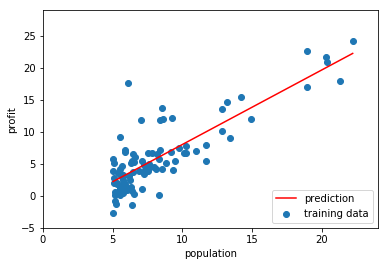

In [44]:
x = np.linspace(df.population.min(), df.population.max(), 50)
y = theta_0 + theta_1 * x
plt.plot(x,y, color = 'red', label = 'prediction')
plt.scatter(df.population, df.profit, label = 'training data')
plt.xlabel('population')
plt.ylabel('profit')
plt.xlim(0, 24)
plt.ylim(-5, 29)
plt.legend(loc = 4)
plt.show()

### Plotting the Surface

The graph of the cost function $J(\theta)$ is a convex (bowl-shaped) surface with a global minimum.  If we start at some point on the surface, then each iteration of the gradient descent algorithm will follow the negative gradient and move us closer and closer to this global minimum.

Part of the graph is plotted below.

In [16]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

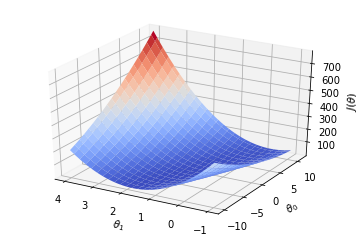

In [23]:
# range for the theta_0, theta_1 axes
theta0_vals = np.linspace(-10, 11, 75) 
theta1_vals = np.linspace(-1, 4, 75)

# initialize J_vals to an array of zeros
J_vals = np.zeros( (len(theta0_vals), len(theta1_vals)) )

# populate J_vals to use them for plotting the surface
for i in range(0, len(theta0_vals)):
    for j in range(0, len(theta1_vals)):
        theta_val = np.matrix( [theta0_vals[i], theta1_vals[j]] )
        J_vals[i,j] = compute_cost(X, y, theta_val) 

# need to transpose J_vals, otherwise axes will be flipped
J_vals = J_vals.T

# make the plot
fig = plt.figure()
ax = fig.gca(projection = '3d')
theta0_vals, theta1_vals = np.meshgrid(theta0_vals, theta1_vals)
surf = ax.plot_surface(theta1_vals, theta0_vals, J_vals, cmap=cm.coolwarm, 
                       rstride=3, cstride=4)
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_0$')
ax.set_zlabel(r'$J(\theta)$')
plt.gca().invert_xaxis()
plt.show()

### Using scikit-learn

...